In [3]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [4]:
#sampling of single node percept field (MH)
def p_w_new(w,x_l,x_r,pi_l,pi_r,var_l,var_r,tau,b,p):
    s_n = w*x_l+(1-w)*x_r
    E_s = (b-s_n)**2
    E_x = 1/(2*var_l)*pi_l*(x_l-s_n)**2+1/(2*var_r)*pi_r*(x_r-s_n)**2
    return np.exp(-tau*(E_x+E_s))

def p_pi_l_new(w,x_l,x_r,pi_l,var_l,b,tau,p):
    s_n = w*x_l+(1-w)*x_r
    E_xl = 1/(2*var_l)*pi_l*(x_l-s_n)**2
    return np.exp(-tau*(E_xl))

def p_pi_r_new(w,x_l,x_r,pi_r,var_r,b,tau,p):
    s_n = w*x_l+(1-w)*x_r
    E_xr = 1/(2*var_r)*pi_r*(x_r-s_n)**2
    return np.exp(-tau*(E_xr))

def proposal_function_new(z, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    z_star = z_star + sigma*random.normal(size = (p))
    return z_star

def binary_proposal_new(z):
    #p: the probability of switch, to stablize the system
    z_star= 1-z
    return z_star

In [5]:
def sample_rejection_w_new(w,w_star,x_l,x_r,pi_l,pi_r,var_l,var_r,b,tau,p):
    p_w_cur = p_w_new(w,x_l,x_r,pi_l,pi_r,var_l,var_r,tau,b,p)
    p_w_star = p_w_new(w_star,x_l,x_r,pi_l,pi_r,var_l,var_r,tau,b,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,p):
    p_pi_l_cur = p_pi_l_new(w,x_l,x_r,pi_l,var_l,b,tau,p)
    p_pi_l_star = p_pi_l_new(w,x_l,x_r,pi_l_star,var_l,b,tau,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,p):
    p_pi_r_cur = p_pi_r_new(w,x_l,x_r,pi_r,var_r,b,tau,p)
    p_pi_r_star = p_pi_r_new(w,x_l,x_r,pi_r_star,var_r,b,tau,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [6]:
def simulation_new(var_l,var_r,tau,b,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones(p)
    x_r = np.zeros(p)
    w = random.rand(p)
    pi_l = random.randint(0,2,(p))
    pi_r = random.randint(0,2,(p))

    s = []
    pi_l_l = []
    pi_r_l = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        #the following for loop update on pi_l
        pi_r_star = binary_proposal_new(pi_r)
        acc_1 = sample_rejection_pi_r_new(w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,p)
        for j in range(p):
            if acc_1[j] == 1:
                pi_r[j] = pi_r_star[j]

        #the following for loop update on pi_r
        pi_l_star = binary_proposal_new(pi_l)
        acc_2 = sample_rejection_pi_l_new(w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,p)
        for j in range(p):
            if acc_2[j] == 1:
                pi_l[j] = pi_l_star[j]
    
            #the following for loop update on w
        w_star = proposal_function_new(w, p)
        acc_3 = sample_rejection_w_new(w,w_star,x_l,x_r,pi_l,pi_r,var_l,var_r,b,tau,p)
        for j in range(p):
            if acc_3[j] == 1:
                w[j] = w_star[j]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
        pi_l_a = pi_l.copy()
        pi_r_a = pi_r.copy()
        pi_l_l.append(pi_l_a)
        pi_r_l.append(pi_r_a)
    return np.array(s),np.array(pi_l_l),np.array(pi_r_l)

In [7]:
def pi_count_1(pi_l,pi_r):
    '''lr = 00,10,01,11'''
    pi_r_1 = pi_r.copy()
    pi_r_1 = pi_r_1*2
    pi_class = pi_r_1+pi_l
    return np.array([len(np.where(pi_class==0)[0])/len(pi_l),len(np.where(pi_class==1)[0])/len(pi_l),len(np.where(pi_class==2)[0])/len(pi_l),len(np.where(pi_class==3)[0])/len(pi_l)])


In [23]:
def cal_expected_pi(var_l,var_r,b_array,tau):
    '''lr = 00,10,01,11'''
    b = b_array.reshape(-1)[0]
    std_00 = 1
    std_01 = (1+1/2/var_l)**-0.5
    std_10 = (1+1/2/var_r)**-0.5
    std_11 = (1+1/2/var_r+1/2/var_l)**-0.5
    k = np.exp(-tau*(b**2+1/2/var_l-(2*b+1/var_l)**2/(1+1/2/var_l+1/2/var_r)/4))
    return np.array([std_00/(std_00+std_01+std_10+k*std_11),std_01/(std_00+std_01+std_10+k*std_11),std_10/(std_00+std_01+std_10+k*std_11),k*std_11/(std_00+std_01+std_10+k*std_11)])

In [24]:
var_l,var_r,tau,b,p,no_sample = 0.001,0.001,1/100,0.5*np.ones(2000),2000,11000
s_0001_0001,pi_l_0001_0001,pi_r_0001_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)
pi_count_1(pi_l_0001_0001.reshape(-1),pi_r_0001_0001.reshape(-1))

array([0.91566555, 0.04099995, 0.04093877, 0.00239573])

In [25]:
cal_expected_pi(0.001,0.001,b,tau)

array([0.91579463, 0.04091469, 0.04091469, 0.00237599])

In [26]:
var_l,var_r,tau,b,p,no_sample = 0.0005,0.0005,1/100,0.5*np.ones(1000),1000,11000
s_00005_00005,pi_l_00005_00005,pi_r_00005_00005 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.001,0.001,1/100,0.5*np.ones(1000),1000,11000
s_0001_0001,pi_l_0001_0001,pi_r_0001_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.002,0.002,1/100,0.5*np.ones(1000),1000,11000
s_0002_0002,pi_l_0002_0002,pi_r_0002_0002 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.003,0.003,1/100,0.5*np.ones(1000),1000,11000
s_0003_0003,pi_l_0003_0003,pi_r_0003_0003 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.004,0.004,1/100,0.5*np.ones(1000),1000,11000
s_0004_0004,pi_l_0004_0004,pi_r_0004_0004 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.005,0.005,1/100,0.5*np.ones(1000),1000,11000
s_0005_0005,pi_l_0005_0005,pi_r_0005_0005 = simulation_new(var_l,var_r,tau,b,p,no_sample)

p_pi_00005_00005 = cal_expected_pi(0.0005,0.0005,b,tau)
p_pi_0001_0001 = cal_expected_pi(0.001,0.001,b,tau)
p_pi_0002_0002 = cal_expected_pi(0.002,0.002,b,tau)
p_pi_0003_0003 = cal_expected_pi(0.003,0.003,b,tau)
p_pi_0004_0004 = cal_expected_pi(0.004,0.004,b,tau)
p_pi_0005_0005 = cal_expected_pi(0.005,0.005,b,tau)

In [27]:
var_l,var_r,tau,b,p,no_sample = 0.003,0.003,1/100,0.5*np.ones(1000),1000,11000
s_0003_0003,pi_l_0003_0003,pi_r_0003_0003 = simulation_new(var_l,var_r,tau,b,p,no_sample)

In [28]:
p_pi_00005_00005_ac = pi_count_1(pi_l_00005_00005.reshape(-1),pi_r_00005_00005.reshape(-1))
p_pi_0001_0001_ac = pi_count_1(pi_l_0001_0001.reshape(-1),pi_r_0001_0001.reshape(-1))
p_pi_0002_0002_ac = pi_count_1(pi_l_0002_0002.reshape(-1),pi_r_0002_0002.reshape(-1))
p_pi_0003_0003_ac = pi_count_1(pi_l_0003_0003.reshape(-1),pi_r_0003_0003.reshape(-1))
p_pi_0004_0004_ac = pi_count_1(pi_l_0004_0004.reshape(-1),pi_r_0004_0004.reshape(-1))
p_pi_0005_0005_ac = pi_count_1(pi_l_0005_0005.reshape(-1),pi_r_0005_0005.reshape(-1))
p_pi_ac = np.array([p_pi_00005_00005_ac,p_pi_0001_0001_ac,p_pi_0002_0002_ac,p_pi_0003_0003_ac,p_pi_0004_0004_ac,p_pi_0005_0005_ac])


In [29]:
p_pi_exp = np.array([p_pi_00005_00005,p_pi_0001_0001,p_pi_0002_0002,p_pi_0003_0003,p_pi_0004_0004,p_pi_0005_0005])

Text(0, 0.5, 'density')

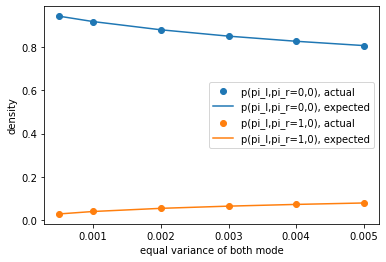

In [30]:
var_array = np.array([0.0005,0.001,0.002,0.003,0.004,0.005])
plt.scatter(var_array,p_pi_ac[:,0])
plt.plot(var_array,p_pi_exp[:,0])
plt.scatter(var_array,p_pi_ac[:,1])
plt.plot(var_array,p_pi_exp[:,1])
plt.legend(['p(pi_l,pi_r=0,0), actual','p(pi_l,pi_r=0,0), expected','p(pi_l,pi_r=1,0), actual','p(pi_l,pi_r=1,0), expected'])
plt.xlabel('equal variance of both mode')
plt.ylabel('density')

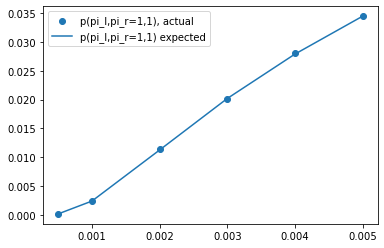

In [31]:
var_array = np.array([0.0005,0.001,0.002,0.003,0.004,0.005])
plt.scatter(var_array,p_pi_ac[:,3])
plt.plot(var_array,p_pi_exp[:,3])
plt.legend(['p(pi_l,pi_r=1,1), actual','p(pi_l,pi_r=1,1) expected'])

In [43]:
var_l,var_r,tau,b,p,no_sample = 0.00025,0.001,1/100,0.5*np.ones(1000),1000,11000
s_000025_0001,pi_l_000025_0001,pi_r_000025_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.0005,0.001,1/100,0.5*np.ones(1000),1000,11000
s_00005_0001,pi_l_00005_0001,pi_r_00005_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.002,0.001,1/100,0.5*np.ones(1000),1000,11000
s_0002_0001,pi_l_0002_0001,pi_r_0002_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.003,0.001,1/100,0.5*np.ones(1000),1000,11000
s_0003_0001,pi_l_0003_0001,pi_r_0003_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.004,0.001,1/100,0.5*np.ones(1000),1000,11000
s_0004_0001,pi_l_0004_0001,pi_r_0004_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

var_l,var_r,tau,b,p,no_sample = 0.005,0.001,1/100,0.5*np.ones(1000),1000,11000
s_0005_0001,pi_l_0005_0001,pi_r_0005_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)

p_pi_000025_0001 = cal_expected_pi(0.00025,0.001,b,tau)
p_pi_00005_0001 = cal_expected_pi(0.0005,0.001,b,tau)
p_pi_0002_0001 = cal_expected_pi(0.002,0.001,b,tau)
p_pi_0003_0001 = cal_expected_pi(0.003,0.001,b,tau)
p_pi_0004_0001 = cal_expected_pi(0.004,0.001,b,tau)
p_pi_0005_0001 = cal_expected_pi(0.005,0.001,b,tau)

In [44]:
var_l,var_r,tau,b,p,no_sample = 0.001,0.001,1/100,0.5*np.ones(1000),1000,11000
s_0001_0001,pi_l_0001_0001,pi_r_0001_0001 = simulation_new(var_l,var_r,tau,b,p,no_sample)
p_pi_0001_0001 = cal_expected_pi(0.001,0.001,b,tau)
p_pi_0001_0001_ac = pi_count_1(pi_l_0001_0001.reshape(-1),pi_r_0001_0001.reshape(-1))

p_pi_exp_1 = np.array([p_pi_000025_0001,p_pi_00005_0001,p_pi_0001_0001,p_pi_0002_0001,p_pi_0003_0001,p_pi_0004_0001,p_pi_0005_0001])

In [45]:
p_pi_000025_0001_ac = pi_count_1(pi_l_000025_0001.reshape(-1),pi_r_000025_0001.reshape(-1))
p_pi_00005_0001_ac = pi_count_1(pi_l_00005_0001.reshape(-1),pi_r_00005_0001.reshape(-1))
p_pi_0001_0001_ac = pi_count_1(pi_l_0001_0001.reshape(-1),pi_r_0001_0001.reshape(-1))
p_pi_0002_0001_ac = pi_count_1(pi_l_0002_0001.reshape(-1),pi_r_0002_0001.reshape(-1))
p_pi_0003_0001_ac = pi_count_1(pi_l_0003_0001.reshape(-1),pi_r_0003_0001.reshape(-1))
p_pi_0004_0001_ac = pi_count_1(pi_l_0004_0001.reshape(-1),pi_r_0004_0001.reshape(-1))
p_pi_0005_0001_ac = pi_count_1(pi_l_0005_0001.reshape(-1),pi_r_0005_0001.reshape(-1))
p_pi_ac_1 = np.array([p_pi_000025_0001_ac,p_pi_00005_0001_ac,p_pi_0001_0001_ac,p_pi_0002_0001_ac,p_pi_0003_0001_ac,p_pi_0004_0001_ac,p_pi_0005_0001_ac])

Text(0, 0.5, 'density')

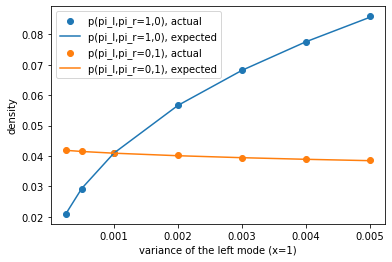

In [46]:
var_array = np.array([0.00025,0.0005,0.001,0.002,0.003,0.004,0.005])
#plt.scatter(var_array,p_pi_ac_1[:,0])
#plt.plot(var_array,p_pi_exp_1[:,0])
plt.scatter(var_array,p_pi_ac_1[:,1])
plt.plot(var_array,p_pi_exp_1[:,1])
plt.scatter(var_array,p_pi_ac_1[:,2])
plt.plot(var_array,p_pi_exp_1[:,2])
plt.legend(['p(pi_l,pi_r=1,0), actual','p(pi_l,pi_r=1,0), expected','p(pi_l,pi_r=0,1), actual','p(pi_l,pi_r=0,1), expected'])
plt.xlabel('variance of the left mode (x=1)')
plt.ylabel('density')


Text(0, 0.5, 'density')

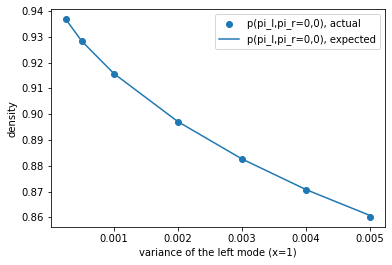

In [47]:
plt.scatter(var_array,p_pi_ac_1[:,0])
plt.plot(var_array,p_pi_exp_1[:,0])
plt.legend(['p(pi_l,pi_r=0,0), actual','p(pi_l,pi_r=0,0), expected'])
plt.xlabel('variance of the left mode (x=1)')
plt.ylabel('density')

Text(0, 0.5, 'density')

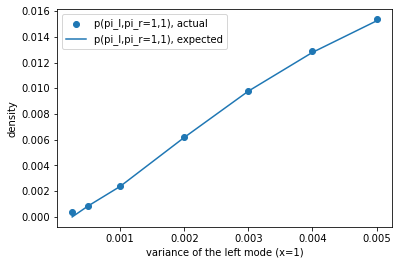

In [41]:
plt.scatter(var_array,p_pi_ac_1[:,3])
plt.plot(var_array,p_pi_exp_1[:,3])
plt.legend(['p(pi_l,pi_r=1,1), actual','p(pi_l,pi_r=1,1), expected'])
plt.xlabel('variance of the left mode (x=1)')
plt.ylabel('density')


In [32]:
np.matmul(np.ones((5,1)),np.ones((1,5)))

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [55]:
s_test = np.ones((2000,5,5))+random.normal(0,1,(2000,5,5))
s_test=s_test.reshape(2000,-1)
s_square = np.matmul(s_test.T,s_test)
s_ave = np.mean(s_test,axis=0)
s_var = np.std(s_test,axis=0)
(s_square/2000-np.matmul(s_ave.reshape(-1,1),s_ave.reshape(1,-1)))/np.matmul(s_var.reshape(-1,1),s_var.reshape(1,-1))

array([[ 1.00000000e+00, -1.54447823e-02,  7.59558322e-03,
        -1.02774509e-02, -4.56460518e-02,  2.06787462e-02,
        -2.98155302e-02,  8.18925122e-03, -3.35783959e-02,
        -4.34275464e-02, -5.30108224e-05, -2.61063745e-02,
        -1.89664540e-02,  2.85192864e-02, -2.80472824e-02,
        -2.50427228e-03, -8.85978505e-03,  3.25748800e-02,
        -2.32984775e-02,  2.68319492e-02, -3.29644575e-02,
         1.36917148e-02, -1.43726784e-02,  6.79879109e-04,
        -2.28321305e-02],
       [-1.54447823e-02,  1.00000000e+00, -1.08401357e-02,
        -6.87073087e-03, -5.32562595e-03, -4.03799022e-02,
         1.09264807e-02, -1.04099854e-02,  4.31837756e-02,
        -1.70956308e-02, -1.65115384e-02,  3.22445991e-02,
         4.60409553e-03, -1.36055142e-02,  1.73455399e-02,
        -1.84212942e-02,  1.18836538e-02,  2.46960880e-02,
         2.78402487e-02,  5.74953784e-03,  8.80526948e-03,
         3.40076473e-02,  6.94778677e-03,  1.27619338e-02,
         6.66568424e-02],
    